In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

import os
from tqdm import tqdm # Fancy progress bars

import seaborn as sns

from tensorflow.keras.utils import load_img,img_to_array
#from keras.utils import load_img, img_to_array
from keras.applications import xception
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix


C:\Users\hi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
             'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [5]:
SAMPLE_PER_CATEGORY = 200
SEED = 7
data_dir = 'C:/Users/hi/git_upload/plant-seedlings-classification/'
train_dir = data_dir+'train'
test_dir = data_dir+'test'
sample_submission = pd.read_csv('C:/Users/hi/git_upload/plant-seedlings-classification/sample_submission.csv')

print(train_dir)
print(test_dir)
print(sample_submission)


C:/Users/hi/git_upload/plant-seedlings-classification/train
C:/Users/hi/git_upload/plant-seedlings-classification/test
              file     species
0    0021e90e4.png  Sugar beet
1    003d61042.png  Sugar beet
2    007b3da8b.png  Sugar beet
3    0086a6340.png  Sugar beet
4    00c47e980.png  Sugar beet
..             ...         ...
789  fea355851.png  Sugar beet
790  fea3da57c.png  Sugar beet
791  fef2ade8c.png  Sugar beet
792  ff65bc002.png  Sugar beet
793  ffc6f8527.png  Sugar beet

[794 rows x 2 columns]


In [6]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(train_dir+'/'+category))))
    # "Print length of this directory -- an integer output"

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Loose Silky-bent 654 images
Maize 221 images
Scentless Mayweed 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [7]:
train = []
for category_id, category in enumerate(CATEGORIES): # category_id is the integer index corresponding to each class_name
    for file in os.listdir(train_dir+'/'+category): # Means: "for every "file" in this directory,:"
        train.append(['train/{}/{}'.format(category, file), category_id, category]) # Renaming the file names and
        # adding to the train list
train = pd.DataFrame(train, columns = ['file', 'category_id', 'category']) # Define a pandas DataFrame over training data
train.head(5) # Print preview of the training DataFrame
train.shape # Check shape: should be of dims (m, 3), where 3 represents file_name, category_id (int index), and class_name
# for each example


,file,category_id,category
0,train/Black-grass/0050f38b3.png,0,Black-grass
1,train/Black-grass/0183fdf68.png,0,Black-grass
2,train/Black-grass/0260cffa8.png,0,Black-grass
3,train/Black-grass/05eedce4d.png,0,Black-grass
4,train/Black-grass/075d004bc.png,0,Black-grass


(4750, 3)

In [8]:


train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1) # pandas function for returning a random sample of items from an axis
# in this case, axis defaults to =0
# The function can either return a specified number of random sample items, or a fraction of them from the selected axis
# frac=1 means we want all of it
train.index = np.arange(len(train)) # This specifies the DataFrame's index (the leftmost "column" counter for m)
train.head(5)
train.shape # Should be same as above, but m decreased due to us selected a random sample from the aggregate training-set

,file,category_id,category
0,train/Sugar beet/3217c1887.png,11,Sugar beet
1,train/Cleavers/6895ae7c9.png,2,Cleavers
2,train/Common wheat/4003af513.png,4,Common wheat
3,train/Black-grass/c0cbaa32c.png,0,Black-grass
4,train/Scentless Mayweed/1247e28dc.png,8,Scentless Mayweed


(2400, 3)

In [9]:
# Similar procedure to creating the training set
# Remember, the test examples are NOT labeled; the labels are not provided for competition purposes
# So, the purpose of this is primarily to collate all the test examples into a neatly organized pandas DataFrame with
# appropriate headers

# Also note that the column 'filepath' is equivalent to the column 'file' in the training set DataFrame

test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(5)
test.shape # We would expect (m, 2) with m being the number of test examples, and 2 being the filepath and file columns

,filepath,file
0,test/0021e90e4.png,0021e90e4.png
1,test/003d61042.png,003d61042.png
2,test/007b3da8b.png,007b3da8b.png
3,test/0086a6340.png,0086a6340.png
4,test/00c47e980.png,00c47e980.png


(794, 2)

In [10]:
# Image is a keras.preprocessing object containing function for preprocessing images for use in keras / tf models
# Essentially, converting images into their corresponding 3-D numpy arrays

# The data_dir is the root-project directory, and the filepaths we have set up nicely when preparing our datasets-in-name
# Thus here, all we have to do is concat the filepaths, and the function will spit out the image file's array format
def read_img(filepath, size):
    img = load_img(os.path.join(data_dir, filepath), target_size = size)
    img = img_to_array(img)
    return img

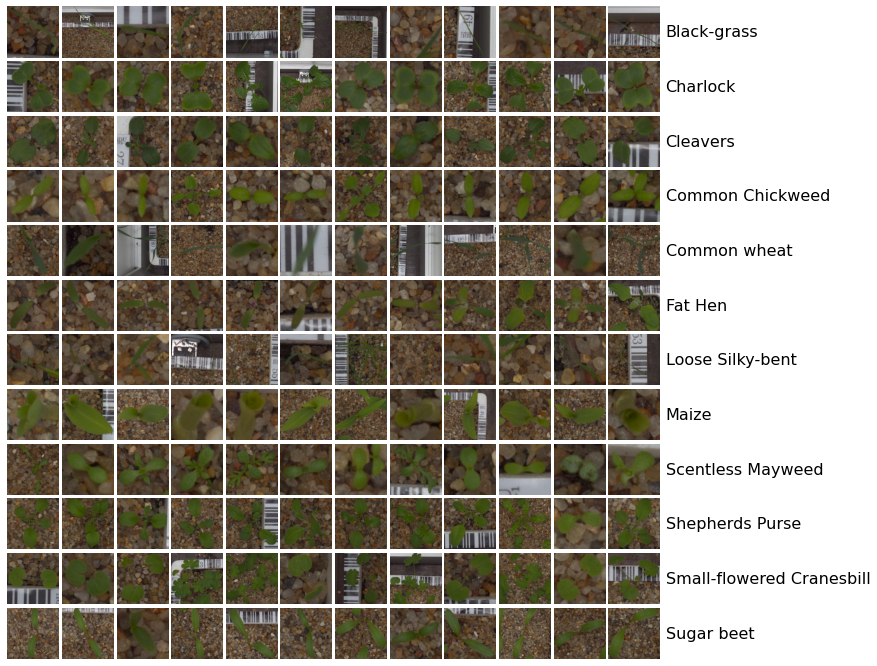

In [12]:
# Using matplotlib for this

fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES)) # Displaying a square matrix with num_categories number of
# images for each category, across all categories
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05) # Set-up grid using 'fig'
i = 0 # Initialize counter

# Iterate through the files in the categories
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224,224)) # read_img function call; filepath specified, img_size hard-coded
        ax.imshow(img/255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1: # Labeling the row-categories (I believe)
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [11]:
# A bit more sophisticated / randomized method of splitting train-dev than simply picking the split index to be
# len(trainset) * split_percentage

np.random.seed(seed=SEED)
rnd = np.random.random(len(train)) # Returns a list of len(train) of 'continuous uniform'
# random distribution floats b/t [0.0, 1.0)
train_idx = rnd < 0.8 # Indices in which rnd is <0.8 (which should come out to roughly 80% of the dataset)
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values # pandas function calls
yv = train.loc[valid_idx, 'category_id'].values
len(ytr)
len(yv)

1925

475

In [12]:
# Specify parameters:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
# Initialize aggregate trainset object of shape (m_total, height, width, channels)

# Fill the numpy array with image files converted into their image-3D arrays
for i, file in tqdm(enumerate(train['file'])): # tqdm is a progress bar
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE)) # Read the filepath into an array via our function call
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0)) # Pre-process that into a format for Xception model
    x_train[i] = x # Set the i-th example in our initialized zero-4D-array to the particular example
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2400it [01:04, 37.15it/s]

Train Images shape: (2400, 299, 299, 3) size: 643,687,200


In [13]:
# Split X into training and validation, now that we have loaded the actual image arrays into x_train

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape)) # Print shapes to confirm dims are correct

((1925, 299, 299, 3), (475, 299, 299, 3), (1925,), (475,))


In [14]:
# Forward propagation through pre-trained Xception model for feature-extraction
# Note: No classification yet in this step

xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING) # Define Xception object
    # based on "off-the-shelf" pre-trained Xception model
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1) # Fwdprop through Xception for feature-extraction
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)

# Check output dims:
print("Xception train bottleneck-features shape: {} size: {:,}".format(train_x_bf.shape, train_x_bf.size))
print("Xception valid bottleneck-features shape: {} size: {:,}".format(valid_x_bf.shape, valid_x_bf.size))

15/15 [==============================] - 48s 3s/step
Xception train bottleneck-features shape: (1925, 2048) size: 3,942,400
Xception valid bottleneck-features shape: (475, 2048) size: 972,800


In [15]:
# xception_bottleneck.summary()
import pickle
pickle.dump(xception_bottleneck,open('final_model.pkl','wb'))

In [16]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000,random_state=SEED)
logreg.fit(train_x_bf, ytr) # We need to fit the classifier to our (X,Y pairs)
valid_probs = logreg.predict_proba(valid_x_bf) # Classification on our dev set -- probabilities of various classes
valid_preds = logreg.predict(valid_x_bf) # Classification on our dev set -- predicted classes


LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=7)

In [25]:
print(valid_x_bf.shape)

(475, 2048)


In [17]:
import pickle
pickle.dump(logreg,open('final_class_model.pkl','wb'))

In [18]:
print("Validation Xception Accuracy: {}".format(accuracy_score(yv, valid_preds)))


Validation Xception Accuracy: 0.8631578947368421


In [19]:
cnf_matrix = confusion_matrix(yv, valid_preds) # Confusion matrix imported from sk-learn
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Loose Silky-bent,LSB
7,Maize,M
8,Scentless Mayweed,SM
9,Shepherds Purse,SP


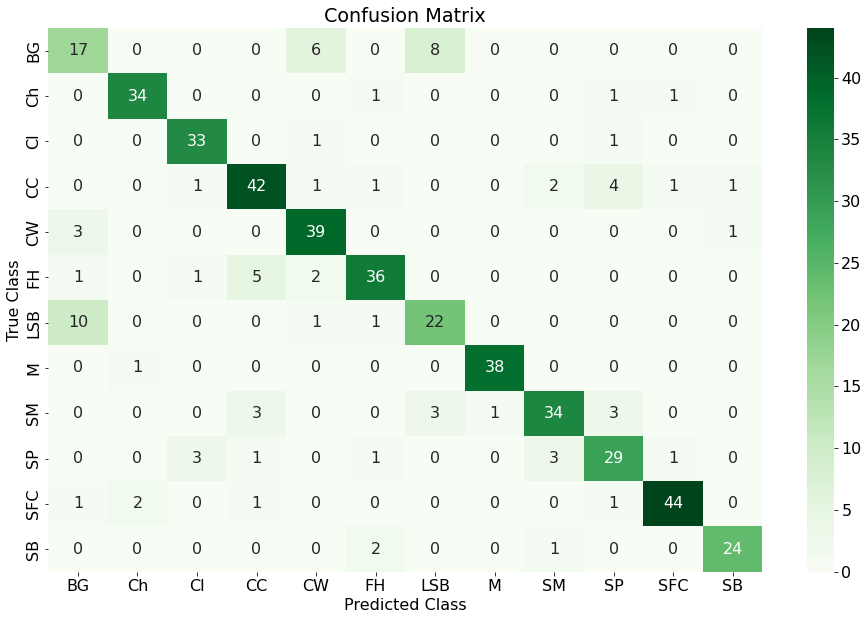

In [25]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [20]:
# Creating the X input objects for the test data
# (similar to how we constructed the 4D input x_train from the filepath object)

x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print("Test images dataset shape: {} size: {:,}".format(x_test.shape, x_test.size))

794it [00:03, 200.79it/s]

Test images dataset shape: (794, 299, 299, 3) size: 212,953,182


In [21]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))

# Run encoded-feature-representations through the Logistic-Regression classifier (by sk-learn)

test_preds = logreg.predict(test_x_bf)

25/25 [==============================] - 77s 3s/step
Xception test bottleneck features shape: (794, 2048) size: 1,626,112


In [22]:
test['category_id'] = test_preds
test['species'] = [CATEGORIES[c] for c in  test_preds]
test[['file', 'species']].to_csv('submission.csv', index=False)
